# Balanced Network De-embedding

Demonstration of *balanced*, i.e. 2N-port, network  de-embedding.

## Setup

In [1]:
import numpy as np
import skrf as rf

rf.stylely()
import matplotlib.pyplot as plt

In [2]:
# base parameters
freq = rf.Frequency(1e-3,10,1001,'ghz')
cpw  =  rf.media.CPW(freq, w=0.6e-3, s=0.25e-3, ep_r=10.6)

# Build fixture network
* short length of mismatched line with connector-like input shunt capacitance
* some crosstalk added with nudge

In [3]:
"""
::
             l1
    0----+-=======-2
         |
         = c1
         |
        GND
        
             l1
    1----+-=======-3
         |
         = c1
         |
        GND
"""


l1 = cpw.line(20, 'mm', z0=50, embed=True)
c1 = cpw.shunt_capacitor(C=0.15e-12, z0=50)
l1 = rf.connect(c1, 1, l1, 0)
li = rf.concat_ports([l1, l1], port_order='second')
Fix = li
Fix.name = 'Fix'
Fix.nudge(1e-4)
Left = Fix
# swap fixture for right side
Fix.renumber([0,1,2,3],
             [2,3,0,1])
Right = Fix

## Build DUT network

* some length of mismatched lines
* some crosstalk added with nudge

In [4]:
"""
::
        l2
    0-=======-2
        l2
    1-=======-3
"""
l2 = cpw.line(50, 'mm', z0=50, embed=True)
DUT = rf.concat_ports([l2, l2], port_order='second')
DUT.name = 'DUT'
DUT.nudge(1e-5)

## Build the measurement

* cascade Left, DUT and Right
* add some noise

In [5]:
Meas = Left ** DUT ** Right
Meas.name = 'Meas'
Meas.add_noise_polar(1e-5, 2)

##  Perform dembedding

In [6]:
DUTd = Left.inv ** Meas ** Right.inv
DUTd.name = 'DUTd'

## Display results

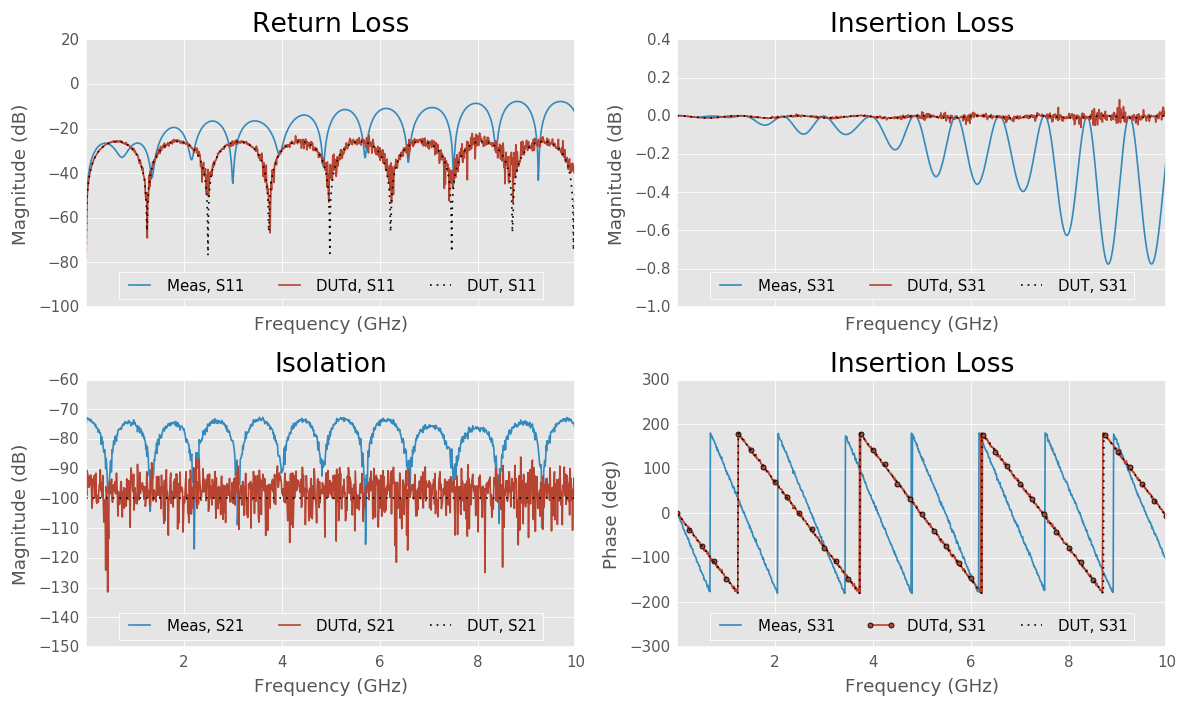

In [7]:

fig, axarr = plt.subplots(2,2, sharex=True, figsize=(10,6))

ax = axarr[0,0]
Meas.plot_s_db(m=0, n=0, ax=ax)
DUTd.plot_s_db(m=0, n=0, ax=ax)
DUT.plot_s_db(m=0, n=0, ax=ax, ls=':', color='0.0')
ax.set_title('Return Loss')
ax.legend(loc='lower center', ncol=3)
ax.grid(True)

ax = axarr[0,1]
Meas.plot_s_db(m=2, n=0, ax=ax)
DUTd.plot_s_db(m=2, n=0, ax=ax)
DUT.plot_s_db(m=2, n=0, ax=ax, ls=':', color='0.0')
ax.set_title('Insertion Loss')
ax.legend(loc='lower center', ncol=3)
ax.grid(True)

ax = axarr[1,0]
Meas.plot_s_db(m=1, n=0, ax=ax)
DUTd.plot_s_db(m=1, n=0, ax=ax)
DUT.plot_s_db(m=1, n=0, ax=ax, ls=':', color='0.0')
ax.set_title('Isolation')
ax.legend(loc='lower center', ncol=3)
ax.grid(True)

ax = axarr[1,1]
Meas.plot_s_deg(m=2, n=0, ax=ax)
DUTd.plot_s_deg(m=2, n=0, ax=ax, marker='o', markevery=25)
DUT.plot_s_deg(m=2, n=0, ax=ax, ls=':', color='0.0')
ax.set_title('Insertion Loss')
ax.legend(loc='lower center', ncol=3)
ax.grid(True)

fig.tight_layout()